In [1]:
import imagesize
import os
import numpy as np
import cv2
from collections import Counter
from tqdm import tqdm

# Print all kinds of image formats present the in dataset 
def print_image_formats():
    image_formats = set()
    for root, dirs, files in os.walk('dataset/images'):
        for file in tqdm(files):
            if (not os.path.isdir(file)):
                image_formats.add(file.split('.')[-1])
    print(image_formats)

print_image_formats() # {'jpg', 'mat'}

100%|██████████| 7393/7393 [00:00<00:00, 41810.20it/s]

{'jpg', 'mat'}


In [2]:
def get_image_sizes(path):
    image_sizes = []
    image_areas = []
    
    # Traverse through all files in the given directory
    for root, dirs, files in os.walk(path):
        for file in tqdm(files):
            if not os.path.isdir(file):
                # Check if the file is a .mat file
                if file.endswith('.mat'):
                    img = cv2.imread(os.path.join(root, file))
                    if img is not None:
                        h, w = img.shape[:2]
                    else:
                        continue
                else:
                    # Get image dimensions for other file types
                    w, h = imagesize.get(os.path.join(root, file))

                # Append image dimensions and area to respective lists
                image_sizes.append((w, h))
                image_areas.append(w * h)
    
    return image_sizes, image_areas

# Get image sizes and areas for images in the dataset
image_sizes, image_areas = get_image_sizes('dataset/images')

100%|██████████| 7393/7393 [00:51<00:00, 143.86it/s]


In [4]:
# Top 5 most common dimensions
counter = Counter(image_sizes)
print(f"Top 5 most common dimensions: {counter.most_common(5)}")

# Smallest dimension
min_dim = min(min(image_sizes, key=lambda x: min(x[0],x[1])))
print(f"Smallest dimension: {min_dim}")

# Largest dimension
max_dim = max(max(image_sizes, key=lambda x: max(x[0],x[1])))
print(f"Largest dimension: {max_dim}")

# Average Dimension
avg_dim = np.mean(image_sizes, axis=0)
print(f"Average Dimension: {avg_dim}")

# Average Area
avg_area = np.mean(image_areas)
sqrt_avg_area = int(np.sqrt(avg_area))
print(f"Average Area: {avg_area}")
print(f"Square root of Average Area: {sqrt_avg_area}")

# Top 5 most common dimensions: [((500, 375), 1425), ((500, 333), 1072), ((375, 500), 511), ((333, 500), 509), ((300, 225), 266)]
# Smallest dimension: 103
# Largest dimension: 3264
# Average Dimension: [436.74519621 390.91366712]
# Average Area: 174861.48240866035
# Square root of Average Area: 418


# Best resize dimension is 256x256
# Prevents excessive upscaling of small images.
# Keeps computational efficiency reasonable.
# Maintains a square format for neural networks.
# Avoids unnecessary interpolation artifacts.


Top 5 most common dimensions: [((500, 375), 1425), ((500, 333), 1072), ((375, 500), 511), ((333, 500), 509), ((300, 225), 266)]
Smallest dimension: 103
Largest dimension: 3264
Average Dimension: [436.74519621 390.91366712]
Average Area: 174861.48240866035
Square root of Average Area: 418


In [ ]:
def image_path_to_annotation_path(image_path):
    # Split the image path into components
    arr = image_path.split(os.sep)
    # Ensure the path has the expected structure
    if len(arr) < 3:
        raise ValueError(f"Unexpected path structure: {image_path}")
    # Replace the 'images' directory with 'annotations/trimaps'
    arr[1] = os.path.join('annotations', 'trimaps')
    # Change the file extension to .png
    arr[2] = os.path.splitext(arr[2])[0] + '.png'
    # Join the components back into a path
    return os.sep.join(arr)

def get_image_paths():
    image_paths = []
    # Traverse through all files in the 'dataset/images' directory
    for root, dirs, files in os.walk(os.path.join('dataset','images')):
        for file in tqdm(files):
            if not os.path.isdir(file):
                img_path = os.path.join(root, file)
                # Get the corresponding annotation path
                try:
                    annotation_path = image_path_to_annotation_path(img_path)
                    image_paths.append((img_path, annotation_path))
                except ValueError as e:
                    print(e)
    return image_paths

image_paths = get_image_paths()

print(image_paths[:5])
print(len(image_paths))


100%|██████████| 7393/7393 [00:00<00:00, 45481.26it/s]

[('dataset\\images\\Abyssinian_1.jpg', 'dataset\\annotations\\trimaps\\Abyssinian_1.png'), ('dataset\\images\\Abyssinian_10.jpg', 'dataset\\annotations\\trimaps\\Abyssinian_10.png'), ('dataset\\images\\Abyssinian_100.jpg', 'dataset\\annotations\\trimaps\\Abyssinian_100.png'), ('dataset\\images\\Abyssinian_100.mat', 'dataset\\annotations\\trimaps\\Abyssinian_100.png'), ('dataset\\images\\Abyssinian_101.jpg', 'dataset\\annotations\\trimaps\\Abyssinian_101.png')]
7393


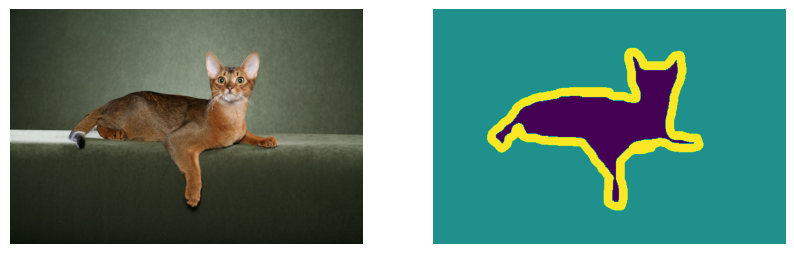

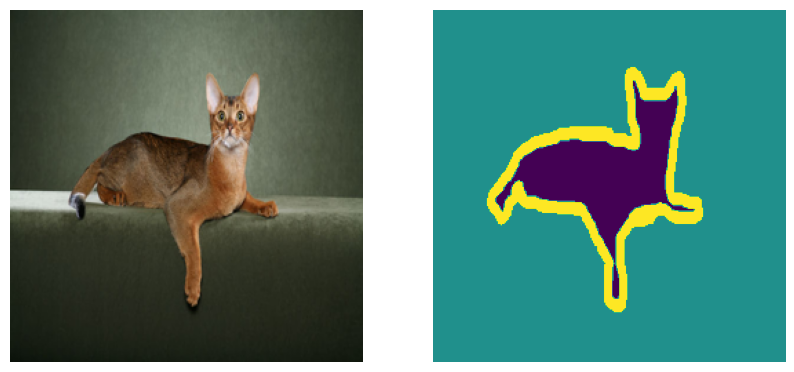

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Function to display an image and its annotation side by side
def display_image_path(image_path, annotation_path=None):
    if annotation_path is not None:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(Image.open(image_path))
        ax[1].imshow(Image.open(annotation_path))
        ax[0].axis('off')
        ax[1].axis('off')
    else:
        plt.imshow(Image.open(image_path))
        plt.axis('off')
    plt.show()

# Function to display an image and its annotation side by side
def display_image(image, annotation=None):
    if annotation is not None:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(image)
        ax[1].imshow(annotation)
        ax[0].axis('off')
        ax[1].axis('off')
    else:
        plt.imshow(image)
        plt.axis('off')
    plt.show()


# Function to resize an image and its annotation to a given size
def resize_image(image_path, annotation_path, size=(256, 256)):
    img = Image.open(image_path)
    annotation = Image.open(annotation_path)
    img_resized = img.resize(size)
    annotation_resized = annotation.resize(size)
    return img_resized, annotation_resized

img_resized, annotation_resized = resize_image(image_paths[0][0], image_paths[0][1])

# Display the resized image and annotation
display_image_path(image_paths[0][0], image_paths[0][1])
display_image(img_resized, annotation_resized)

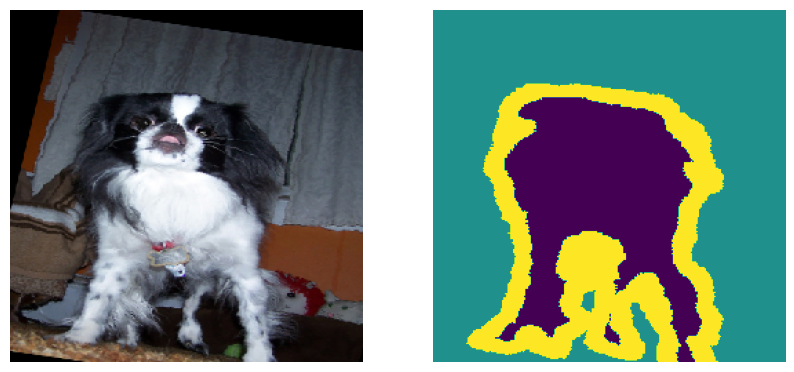

[1 2 3]


In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import random

dim = 256

# Define the augmen5ation pipeline
augmentation_pipeline = A.Compose([
    A.ElasticTransform(alpha=10, sigma=20, p=0.5, border_mode=cv2.BORDER_REFLECT_101),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Affine(translate_percent=0.05, scale=(0.9, 1.1), rotate=(-30, 30), p=0.5, cval=0, mode=cv2.BORDER_CONSTANT),
    A.Resize(dim, dim, interpolation=cv2.INTER_NEAREST),  # Ensure no interpolation in segmentation mask
    ToTensorV2()
])

# Function to augment an image and its annotation
# The annotation is augmented using the same transformations as the image
def augment_image(image, annotation):
    augmented = augmentation_pipeline(image=image, mask=annotation)
    return augmented['image'], augmented['mask']

i = random.randint(0, len(image_paths))

image = np.array(Image.open(image_paths[i][0]))
annotation = np.array(Image.open(image_paths[i][1]))

augmented_image, augmented_annotation = augment_image(image, annotation)

# replace 0 with 2 in the annotation to retain the original background class
augmented_annotation[augmented_annotation == 0] = 2

display_image(augmented_image.permute(1, 2, 0).numpy(), augmented_annotation.numpy())

# print values of annotations
print(np.unique(augmented_annotation))

In [ ]:
import scipy.io

dim = 256

trainval = 'dataset/annotations/trainval.txt'  # File containing list of image paths for training and validation

# Create directories for augmented images and annotations if they don't exist
if not os.path.exists(f'trainval_{dim}'):
    os.makedirs(os.path.join(f'trainval_{dim}', 'images'))
    os.makedirs(os.path.join(f'trainval_{dim}', 'annotations'))

# Read the file containing image paths
with open(trainval, 'r') as f:
    lines = f.readlines()

# Process each image and its corresponding annotation
for line in tqdm(lines):
    image_file = line.split()[0]
    image_path = os.path.join('dataset', 'images', image_file + '.jpg')
    if not os.path.exists(image_path):
        image_path = image_path.replace('.jpg', '.mat')
    
    annotation_path = os.path.join('dataset', 'annotations', 'trimaps', image_file + '.png')

    # Load image based on its format
    if image_path.endswith('.mat'):
        mat = scipy.io.loadmat(image_path)
        image = mat['image']  # Adjust the key based on the actual structure of your .mat file
    else:
        image = np.array(Image.open(image_path))
    
    annotation = np.array(Image.open(annotation_path))

    # Augment the image and its annotation
    aug_image, aug_annotation = augment_image(image, annotation)

    # Replace 0 with 2 in the annotation to retain the original background class
    aug_annotation[aug_annotation == 0] = 2

    # Define paths to save augmented images and annotations
    aug_image_path = os.path.join(f'trainval_{dim}', 'images', image_file + '.png')
    aug_annotation_path = os.path.join(f'trainval_{dim}', 'annotations', image_file + '.png')

    # Save augmented image and annotation
    aug_image_rgb = Image.fromarray(aug_image.permute(1, 2, 0).numpy()).convert('RGB')
    aug_image_rgb.save(aug_image_path)
    Image.fromarray(aug_annotation.numpy()).save(aug_annotation_path)

100%|██████████| 3680/3680 [02:14<00:00, 27.32it/s]


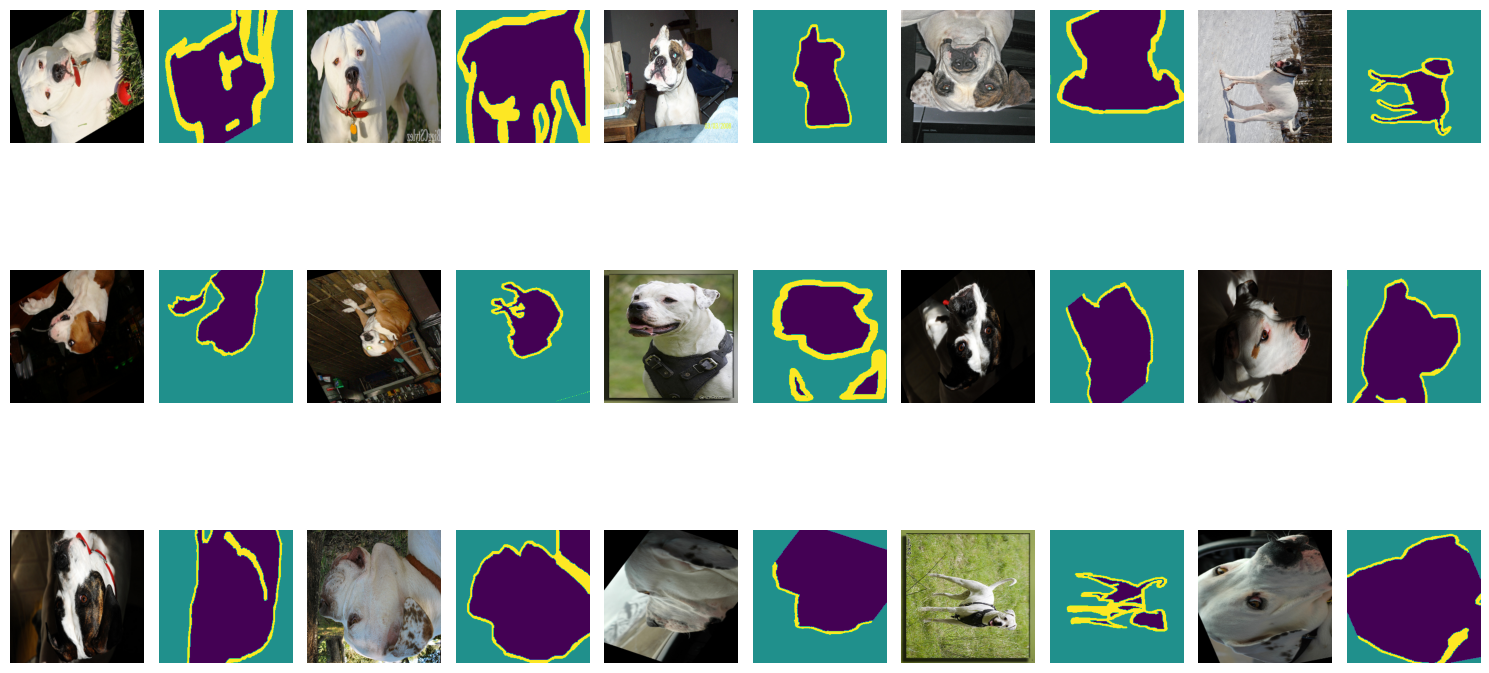

In [10]:
# show off 15 augmentations (3*5) with trimaps

fig, axes = plt.subplots(3, 10, figsize=(15, 9))
for i in range(15):
    
    image = np.array(Image.open(image_paths[i+250][0]))
    annotation = np.array(Image.open(image_paths[i+250][1]))
    aug_image, aug_annotation = augment_image(image, annotation)
    aug_annotation[aug_annotation == 0] = 2
    
    axes[i // 5, (i % 5) * 2].imshow(aug_image.permute(1, 2, 0).numpy())
    axes[i // 5, (i % 5) * 2].axis('off')
    axes[i // 5, (i % 5) * 2 + 1].imshow(aug_annotation.numpy())
    axes[i // 5, (i % 5) * 2 + 1].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
# Make array for test set image paths and annotations to be saved in a pickle for later use.

test = 'dataset/annotations/test.txt' # contains list of image paths for testing

test_image_paths = []
test_trimap_paths = []

with open(test, 'r') as f:
    lines = f.readlines()

for line in tqdm(lines):
    image_file = line.split()[0]
    image_path = os.path.join('dataset', 'images', image_file + '.jpg')
    if not os.path.exists(image_path):
        image_path = image_path.replace('.jpg', '.mat')
    
    annotation_path = os.path.join('dataset', 'annotations', 'trimaps', image_file + '.png')

    test_image_paths.append(image_path)
    test_trimap_paths.append(annotation_path)

# Save
import pickle

with open('test_image_paths.pkl', 'wb') as f:
    pickle.dump(sorted(test_image_paths), f)

with open('test_trimap_paths.pkl', 'wb') as f:
    pickle.dump(sorted(test_trimap_paths), f)

print(test_image_paths[:5])
print(test_trimap_paths[:5])
print(len(test_image_paths)) # 152

100%|██████████| 3669/3669 [00:00<00:00, 11230.59it/s]

['dataset\\images\\Abyssinian_201.jpg', 'dataset\\images\\Abyssinian_202.jpg', 'dataset\\images\\Abyssinian_204.jpg', 'dataset\\images\\Abyssinian_205.jpg', 'dataset\\images\\Abyssinian_206.jpg']
['dataset\\annotations\\trimaps\\Abyssinian_201.png', 'dataset\\annotations\\trimaps\\Abyssinian_202.png', 'dataset\\annotations\\trimaps\\Abyssinian_204.png', 'dataset\\annotations\\trimaps\\Abyssinian_205.png', 'dataset\\annotations\\trimaps\\Abyssinian_206.png']


3669
